In [30]:
import numpy as np
from operator import xor

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from classifier import *
from ntk import *
from Q_minimization import *

### Define Dimensions

In [472]:
n = 1000
m = 10
d = 10

### Define Dataset

In [473]:
def xor_label(row):
    _xor = xor(bool(row[1] > 0), bool(row[2] > 0))
    return 1.0 if _xor else -1.0

In [474]:
x = 2.0 * ((np.random.normal(size=(n, d - 1)) > 0) - 0.5)
x = np.concatenate([np.ones((n, 1)), x], axis=1)

y = np.array(list(map(xor_label, x))).reshape(-1,)

In [475]:
x_train, x_test = x[: int(0.8 * n), :], x[int(0.8 * n):, :]
y_train, y_test = y[: int(0.8 * n)], y[int(0.8 * n):]

### Utils

In [519]:
def plot_classifier(w, a, x, y):
	xmin = -1.2
	xmax = 1.2

	mesh_step = 0.02
	_x1 = np.arange(xmin, xmax, mesh_step)
	_x2 = np.arange(xmin, xmax, mesh_step)
	xx_1, xx_2 = np.meshgrid(_x1, _x2)

	input_ = np.c_[np.ones(xx_1.ravel().shape), xx_1.ravel(), xx_2.ravel(), 1.0 * ((np.random.normal(size=(len(xx_1.ravel()), d - 3)) > 0))]
	activations = np.maximum(np.dot(w, input_.transpose()), 0)
	y_pred = np.dot(a, activations)

	plt.figure()
	z = np.reshape(np.sign(y_pred), xx_1.shape)
	plt.pcolormesh(xx_1, xx_2, z)

	plt.scatter([x_[1] for x_, y_ in zip(x, y) if y_ > 0], [x_[2] for x_, y_ in zip(x, y) if y_ > 0])
	plt.scatter([x_[1] for x_, y_ in zip(x, y) if y_ < 0], [x_[2] for x_, y_ in zip(x, y) if y_ < 0])
	plt.show()

### Solve L1

In [520]:
w_0 = np.random.normal(loc=0, scale=1, size=(m, d))
a_0 = np.random.normal(loc=0, scale=1, size=(m,))

In [521]:
w_opt_L1, a_opt_L1 = solver(x, y, w_0, a_0, m, d, obj='L1')
w_opt_L1, a_opt_L1

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.3784144420389484
            Iterations: 301
            Function evaluations: 34871
            Gradient evaluations: 299


(array([[ 5.74540688e-08,  5.83730182e-01, -5.83730217e-01,
          5.47992487e-08,  2.14863141e-08, -1.33927478e-08,
         -9.96039186e-10, -5.59326097e-10,  3.30619966e-08,
          3.33007716e-09],
        [-4.39461934e-08,  5.79257203e-01,  5.79257218e-01,
          3.83741017e-08, -4.47526662e-09,  2.82155558e-09,
         -3.17667277e-09,  3.08023389e-08, -2.65650811e-08,
          2.81399674e-08],
        [ 7.13012393e-06,  2.50008604e-03, -2.50291675e-03,
          3.25800782e-06, -7.36691488e-06,  6.63340188e-06,
         -2.52555109e-06,  4.11005978e-06, -2.46482988e-06,
         -3.49943525e-06],
        [-3.59823659e-08,  1.33779803e-01,  1.33779823e-01,
          7.71921819e-08,  9.08499089e-10,  9.62456661e-08,
         -8.53827402e-09, -8.50716422e-08, -9.50265752e-10,
         -1.13935657e-07],
        [-7.08900107e-08, -5.60887042e-01, -5.60887066e-01,
          4.65104632e-08,  7.66715954e-09,  2.26058923e-08,
         -3.98045112e-08,  1.66629917e-08,  2.863163

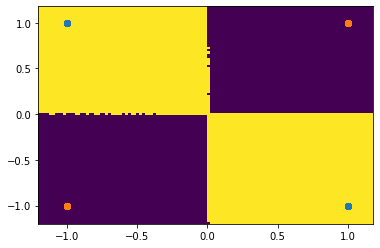

In [522]:
plot_classifier(w_opt_L1, a_opt_L1, x, y)

In [523]:
w_tilde_norms_opt_L1 = calc_w_tilde_norms(w_opt_L1, a_opt_L1)

In [524]:
minimal_margin(w_opt_L1, a_opt_L1, x, y)

0.9999999540786542

### Create Symmetric Initialization

In [460]:
alpha = 1000
s = 0.8

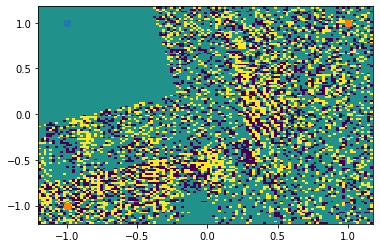

In [461]:
w_0, a_0 = symmetric_init(alpha=alpha, s=s,  m=m, d=d)
plot_classifier(w_0, a_0, x, y)

### Train Full Model

In [525]:
def train(x_train, y_train, x_test, y_test, w_0, a_0, step_size, n_epochs):
    training_accuracy = []
    test_accuracy = []
    excess_l1_curve = []

    w, a = np.array(w_0), np.array(a_0)

    for epoch in range(n_epochs):
        w, a, gamma_tilde, gamma = update(w, a, x_train, y_train, epoch, step_size)
        training_accuracy.append(gamma_tilde)
        test_accuracy.append(evaluate(x_test, y_test, w, a))
        
        w_tilde_norms = calc_w_tilde_norms(w, a) / gamma
        excess_l1 = np.linalg.norm(w_tilde_norms, ord=1) / np.linalg.norm(w_tilde_norms_opt_L1, ord=1) - 1
        excess_l1_curve.append(excess_l1)


    return {
        'w': w,
        'a': a,
        'training_accuracy': training_accuracy,
        'test_accuracy': test_accuracy,
        'excess_l1_curve': excess_l1_curve
    }

In [526]:
def evaluate(x, y, w, a):
    activations = np.maximum(np.dot(w, x.transpose()), 0)
    y_pred = np.dot(a, activations)
    return sum(np.equal(np.sign(y_pred), np.sign(y))) / len(x)

In [542]:
alpha = 10

results = {}
for s in [0, 0.5, 0.9]:
    w_0, a_0 = symmetric_init(alpha=alpha, s=s,  m=m, d=d)
    results[s] = train(x_train, y_train, x_test, y_test, w_0, a_0, step_size=0.1, n_epochs=10000)

/Users/shaharazulay/anaconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


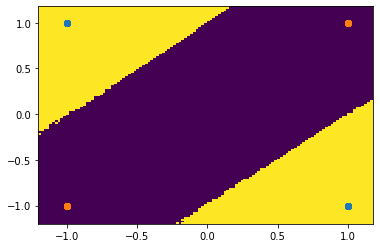

In [543]:
w, a = results[0]['w'], results[0]['a']
plot_classifier(w, a, x_train, y_train)

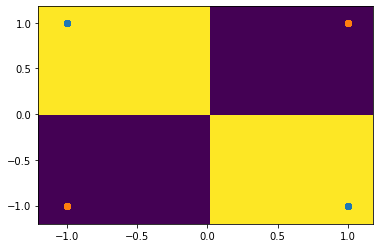

In [544]:
w, a = results[0.9]['w'], results[0.9]['a']
plot_classifier(w, a, x_train, y_train)

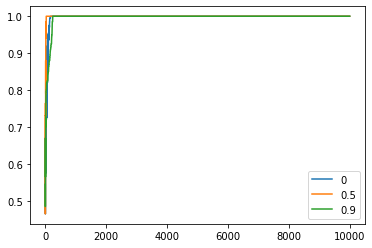

In [545]:
for k in results.keys():
    plot(results[k]['test_accuracy'])

legend(results.keys())
#yscale('log')
#xlim([0, 100])

In [546]:
results[0.9]['training_accuracy'][-1]

7711061.616864997

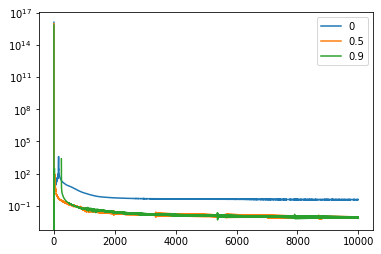

In [547]:
for k in results.keys():
    plot(results[k]['excess_l1_curve'])

yscale('log')
legend(results.keys())